In [1]:
#Sci-kit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

#Torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetRegressor

#xg-boost
import xgboost as xgb

from visualization.visualize import *
from data.data_loader import *
from models.training import trainModels
from models.model import Model
from models.quantileregression.conformalprediction import *
from models.quantileregression.pinball import *
from models.neuralnetwork.architecture import *

In [2]:
dirParquet = "../data/intermediate/"
df = loadDataParquet(dirParquet)


In [3]:
### DATA PREPARATION ###
dependentCol = "UL_bitrate"

selectedFloatCols = ["Longitude", "Latitude", "Speed", "RSRP","RSRQ","SNR"]
selectedCatCols = ["CellID"]

dataX, dataY = processData(df, selectedFloatCols,selectedCatCols, dependentCol)
dataX.size


460180

In [4]:
### DIVIDE INTO TRAINING, VALIDATION AND TEST ###
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

xTrain, xTest, yTrain, yTest = train_test_split(dataX, dataY, test_size=1 - train_ratio)
xVal, xTest, yVal, yTest = train_test_split(xTest, yTest, test_size=test_ratio/(test_ratio + validation_ratio))


In [5]:
### SELECT MODELS ###
alpha = 0.1
lowerNet = NeuralNetRegressor(
    ThroughputPredictor,
    module__input_size=dataX.shape[1],  # Pass the input size to the module
    optimizer=optim.Adam,               # Optimizer
    criterion=PinballLoss(alpha/2),               # Loss function
    verbose=0,                          # Silence verbose output
    train_split=None                    # Disable internal train/val split, we'll use external CV
)
upperNet = NeuralNetRegressor(
    ThroughputPredictor,
    module__input_size=dataX.shape[1],  # Pass the input size to the module
    optimizer=optim.Adam,               # Optimizer
    criterion=PinballLoss(1-alpha/2),               # Loss function
    verbose=0,                          # Silence verbose output
    train_split=None                    # Disable internal train/val split, we'll use external CV
)
regularNet = NeuralNetRegressor(
    ThroughputPredictor,
    module__input_size=dataX.shape[1],  # Pass the input size to the module
    optimizer=optim.Adam,               # Optimizer
    criterion=PinballLoss(1-alpha/2),               # Loss function
    verbose=0,                          # Silence verbose output
    train_split=None                    # Disable internal train/val split, we'll use external CV
)
paramGridNetLower = {
    'lr': [0.01],
    'max_epochs': [100],
    'optimizer__weight_decay': [0.01],
    'batch_size': [128]
}
paramGridNetUpper = {
    'lr': [0.01],
    'max_epochs': [100],
    'optimizer__weight_decay': [0.01],
    'batch_size': [128]
}
paramGridNetRegular = {
    'lr': [0.01],
    'max_epochs': [100],
    'optimizer__weight_decay': [0.01],
    'batch_size': [128]
}
lowerScorer = pinballLossScorer(alpha/2)
upperScorer = pinballLossScorer(1-alpha/2)
lowerModel = Model(lowerNet, "Lower Bound Neural Network", paramGridNetLower, lowerScorer)
upperModel = Model(upperNet, "Upper Bound Neural Network", paramGridNetUpper, upperScorer)

conformalScoreFunc = lambda X,Y: pinballConformalScoreFunc(lowerModel, upperModel, X, Y)

In [6]:
### TRAINING ###
quantileRegressor = QuantileRegressor(lowerModel, upperModel)
conformalPredictor = ConformalizedQuantileRegressor(quantileRegressor, conformalScoreFunc, alpha)
conformalPredictor.fit(xTrain, yTrain, xVal, yVal, 3)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/eriklinde/Einride/msc-degree-project/.venv/lib/python3.9/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/eriklinde/Einride/msc-degree-project/.venv/lib/python3.9/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **

Quantile regression coverage: 0.9178974804517811
Conformal prediction coverage: 0.9178974804517811
Average conformal prediction width: 264.75116


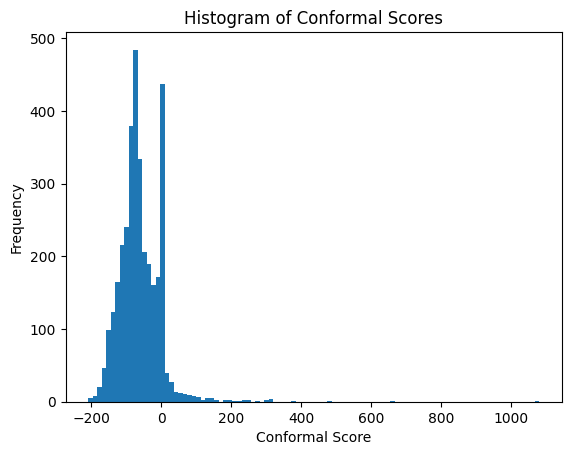

In [7]:
### EVALUATION ###
print("Quantile regression coverage:", quantileRegressor.getCoverageRatio(xTest, yTest))
print("Conformal prediction coverage:", conformalPredictor.getCoverageRatio(xTest, yTest))

print("Average conformal prediction width:", conformalPredictor.getAverageIntervalWidth(xTest))

conformalScores = conformalScoreFunc(xVal, yVal)
plt.hist(conformalScores, bins=100)
plt.xlabel('Conformal Score')
plt.ylabel('Frequency')
plt.title('Histogram of Conformal Scores')
plt.show()


In [8]:
### POINT ESTIMATION MODELS ###
rf = RandomForestRegressor(random_state=42)
paramGridRf = {
    'n_estimators': [300],
    'max_depth': [20],
    'min_samples_split': [5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

xGradBoost = xgb.XGBRegressor(random_state=42)
paramGridXgb = {
    'n_estimators': [200],
    'learning_rate': [0.05],
    'max_depth': [5],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0.1],
    'reg_alpha': [0.01],
    'reg_lambda': [1.5]
}

net = NeuralNetRegressor(
    ThroughputPredictor,
    module__input_size=dataX.shape[1],  # Pass the input size to the module
    optimizer=optim.Adam,               # Optimizer
    criterion=nn.MSELoss,               # Loss function
    verbose=0,                          # Silence verbose output
    train_split=None                    # Disable internal train/val split, external CV used
)
paramGridNet = {
    'lr': [0.01],
    'max_epochs': [100],
    'optimizer__weight_decay': [0.01],
    'batch_size': [128]
}

models = [Model(rf, "Random Forest", paramGridRf), Model(xGradBoost, "XGBoost", paramGridXgb), Model(net, "Neural Network", paramGridNet)]


In [9]:
_ = trainModels(models, xTrain, yTrain, xVal, yVal, xTest, yTest)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters for Random Forest: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Training MSE: 3608.01
Training R^2: 0.64
Validation MSE: 6562.81
Validation R^2: 0.32
Test MSE: 5532.00
Test R^2: 0.32

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Parameters for XGBoost: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0.01, 'reg_lambda': 1.5, 'subsample': 0.8}
Training MSE: 7276.54
Training R^2: 0.28
Validation MSE: 7749.32
Validation R^2: 0.20
Test MSE: 6737.23
Test R^2: 0.17

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/eriklinde/Einride/msc-degree-project/.venv/lib/python3.9/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **

Best Parameters for Neural Network: {'batch_size': 128, 'lr': 0.01, 'max_epochs': 100, 'optimizer__weight_decay': 0.01}
Training MSE: 8109.39
Training R^2: 0.20
Validation MSE: 8101.72
Validation R^2: 0.16
Test MSE: 6993.69
Test R^2: 0.14



In [10]:

for model in models: 
    yPred = model.predict(xTest)
    predIntervalCoverRatio = conformalPredictor.getCoverageRatio(xTest, yPred)
    print(f"{model.getName()} - cover %: {predIntervalCoverRatio}")

Random Forest - cover %: 0.9891398783666377
XGBoost - cover %: 0.9986967854039965
Neural Network - cover %: 0.9991311902693311
